# 🏛️ **Классификация объектов имущества на основе векторных представлений текстов судебных актов ВС РФ**  
*Автоматизация анализа юридических текстов с помощью VM & ML*  

---

### 🔍 **Цель проекта**  
**Разработать модель машинного обучения**, способную классифицировать объекты имущества (движимое / недвижимое / улучшение) на основе векторного представления текстов судебных решений Верховного Суда РФ, учитывая **смысловую неоднозначность**, **противоречивость судебной практики** и **дефицит четких маркеров**.  

---

### ⚖️ **Проблематика и ключевые сложности**  

#### 📜 **1. Неопределенность юридического языка**  
- **Категории «размыты»**: формулировки вроде «прочная связь с землей» или «функциональное назначение» интерпретируются **субъективно**.  
- *Пример*: Один и тот же объект (например, сборный павильон) в разных решениях может быть признан и движимым, и недвижимым имуществом.  

#### 🔄 **2. Противоречивая судебная практика**  
- **Аналогичные дела — разные выводы**: Суды могут противоположно квалифицировать объекты при схожих обстоятельствах (например, из-за различий в региональной практике).  
- *Кейс*: Доски для забора до монтажа = `MO`, после монтажа = `FIX`, но иногда и `IMO` — если забор капитальный.  

#### 📉 **3. Дефицит данных и информационный шум**  
- **Мало значимых примеров**: В 95% решений объекты очевидны (здания, автомобили), а нужны именно **«пограничные» случаи** (например, мобильные сооружения).  
- **Тексты перегружены** procedural noise: описания процессуальных действий, ссылки на нормы, повторяющиеся шаблоны.  

#### 🧩 **4. Сложность выявления значимых признаков**  
- **Пересекающиеся критерии**:  
  - *Материал* («металлоконструкции» → `MO` или `IMO`?)  
  - *Способ монтажа* («демонтаж без ущерба» → `MO`)  
  - *Назначение* («временное vs. постоянное»).  
- **Контекстная зависимость**: Фраза «объект не имеет фундамента» может указывать на `MO`, но если добавлено «однако интегрирован в систему коммуникаций» → `IMO`.  

---

### 🎯 **Задачи проекта**  

#### 📂 **1. Подготовка данных**  
- **EDA**: анализ распределения данных по категориям; анализ текстовых данных ДО и ПОСЛЕ очистки
- **Очистка и предобработка данных**: лемматизация, обработка стоп-слов, обработка с помощью рег. выражений и др.  

#### 🔠 **2. Векторизация текста**  
- **TF-IDF**: учет униграмм и биграмм, а также минимальной встречаемости признаков.  
- **Предобученные эмбеддинги + веса TF-IDF**: использование предобученных моделей для русского языка с учетом важности ключевых слов в корпусе.  

#### 🤖 **3. Обучение моделей**  
- **Интерпретируемые алгоритмы**: `Random Forest` для анализа важности признаков.  
- **Градиентный бустинг** (`LightGBM`).  

#### 📊 **4. Интерпретация результатов**  
- **Важность терминов**: Какие слова чаще ведут к классификации `IMO`/`MO` (например, «демонтаж» → `MO`, «кадастровый учет» → `IMO`).  
- **Анализ ошибок**: В каких случаях модель ошибается и почему (например, путает `FIX` и `IMO`).  

---

### 🛠️ **Ожидаемые результаты**  
- **Модель с точностью >80%** на «пограничных» кейсах.  
- **Список значимых критериев**, используемых судами (например, суды чаще признают объект `IMO`, если упомянут «кадастровый учет» + «инженерные сети»).  

---

### 📌 **Потенциальное применение**  
- **Для юристов**: Модель может быть положена в основу сервиса для предсказания позиции суда по спорным объектам, визуализация противоречий в судебной практике со схожими обстоятельствами (например, визуализация карты кейсов, где практика расходится).  
- **Для законодателей**: Выявление «зон неопределенности» в регулировании (анализ противоричивой судебной практики при применении одной и той же нормы закона в схожих обстоятельствах).  
- **Для науки**: моделирование значимых признаков и предсказание классов, соответствующих базовым юридическим категория (стык лингвистики, CS и юриспруденции).  

---

**🔮**: Проект лежит на стыке права и ML, требуя не только технических решений, но и глубокого понимания юридического контекста.**

## Установка необходимых библиотек и модулей


In [2]:
!pip install pymorphy3
!pip install wget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 76.9 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=bb9fef8a49b4093be657074f584a3e4edd7037824728155995e39810db7d3b1b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import numpy as np
import pandas as pd
import re
import wget

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from datetime import datetime
from tqdm.auto import tqdm

import pymorphy3

from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
from nltk import download
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib

tqdm.pandas()
sns.set(palette='muted')

## Подготовка данных
### Общая информация

In [4]:
df_real_estate = pd.read_excel('/kaggle/input/df-real-estate/___.xlsx')

In [5]:
pd.set_option('display.max_colwidth', 1000)

In [5]:
df_real_estate.sample(3)

,decision_date,case_number,text,target
61,2022-06-06,308-ЭС22-7742,"ВЕРХОВНЫЙ СУД \nРОССИЙСКОЙ ФЕДЕРАЦИИ \n№ 308-ЭС22-7742 \nОПРЕДЕЛЕНИЕ\nг. Москва 06 июня 2022 г. \n Судья Верховного Суда Российской Федерации Антонова М.К., изучив кассационную жалобу публичного акционерного общества ""Вторая генерирующая компания оптового рынка электроэнергии"" (далее - общество, налогоплательщик) на решение Арбитражного суда Ростовской области от 02.09.2021, постановление Пятнадцатого арбитражного апелляционного суда от 13.11.2021 и постановление Арбитражного суда Северо-Кавказского округа от 11.03.2022 по делу № А53-3299/2021 по заявлению общества о признании недействительным решения Межрайонной инспекции Федеральной налоговой службы № 13 по Ростовской области (далее - инспекция, налоговый орган) от 08.09.2020 № 485,\nустановил: \n решением суда первой инстанции от 02.09.2021, оставленным без изменения постановлениями Пятнадцатого арбитражного апелляционного суда от 13.11.2021 и Арбитражного суда Северо-Кавказского округа от 11.03.2022, в удовлет...",IMO
88,2021-12-15,306-ЭС21-24960,"ВЕРХОВНЫЙ СУД\nРОССИЙСКОЙ ФЕДЕРАЦИИ\n№ 306-ЭС21-24960\n\nОПРЕДЕЛЕНИЕ\nг. Москва 15 декабря 2021 г.\n Судья Верховного Суда Российской Федерации Грачева И.Л., изучив кассационную жалобу Волгоградского областного отделения общественной организации ""Всероссийское общество автомобилистов"" (Волгоград) на постановление Двенадцатого арбитражного апелляционного суда от 28.06.2021 и постановление Арбитражного суда Поволжского округа от 10.09.2021 по делу № А12-23764/2020, \nустановил:\n Департамент муниципального имущества администрации Волгограда (далее - Департамент) обратился в Арбитражный суд Волгоградской области с иском к Волгоградскому областному отделению общественной организации ""Всероссийское общество автомобилистов"" (далее - Общественная организация) о признании отсутствующим права собственности на объект незавершенного строительства - иное сооружение (автостоянка) с кадастровым номером 34:34:030052:2564, расположенное на земельном участке с кадастровым номером 34:34:0300...",FIX
99,2021-12-23,305-ЭС21-25288,"ВЕРХОВНЫЙ СУД\nРОССИЙСКОЙ ФЕДЕРАЦИИ\n№ 305-ЭС21-25288\n \nОПРЕДЕЛЕНИЕ\nг. Москва 23.12.2021\n Судья Верховного Суда Российской Федерации Попов В.В., изучив кассационную жалобу общества с ограниченной ответственностью ""Мир"" (далее - общество) на решение Арбитражного суда Московской области от 19.05.2021, постановление Десятого арбитражного апелляционного суда от 05.07.2021 и постановление Арбитражного суда Московского округа от 29.09.2021 по делу № 41-85217/2020, \nустановил:\n общество обратилось в Арбитражный суд Московской области с заявлением к Администрации городского округа Солнечногорск (далее - администрация) о признании незаконным решения от 20.10.2020 № Р001-5480916322- 38933641 об отказе в предоставлении в собственность земельного участка с кадастровым номером 50:09:0020603:366, о признании за обществом права на приобретение в собственность без проведения торгов земельного участка с кадастровым номером 50:09:0020603:366, общей площадью 2.527 кв.м, категория зем...",FIX


In [6]:
print(f"Размерность данных: {df_real_estate.shape}")

Размерность данных: (110, 4)


In [7]:
print("\nИнформация о данных:")
df_real_estate.info()


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   decision_date  110 non-null    datetime64[ns]
 1   case_number    106 non-null    object        
 2   text           110 non-null    object        
 3   target         110 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.6+ KB


In [8]:
# Проверка на пропущенные значения
print("\n=== Пропущенные значения ===")
print(df_real_estate.isnull().sum())


=== Пропущенные значения ===
decision_date    0
case_number      4
text             0
target           0
dtype: int64


In [9]:
print("\n=== Дубликаты ===")
print(df_real_estate.duplicated().sum())


=== Дубликаты ===
0


**Видим:**

- тип данных соответствует их природе;
- датасет не содержит дубликатов;
- в колонке `case_number` содержится 4 пропуска, для нас они незначимы, так как представляют собой по сути id судебного акта

### EDA: распределение по годам и категориям имущества

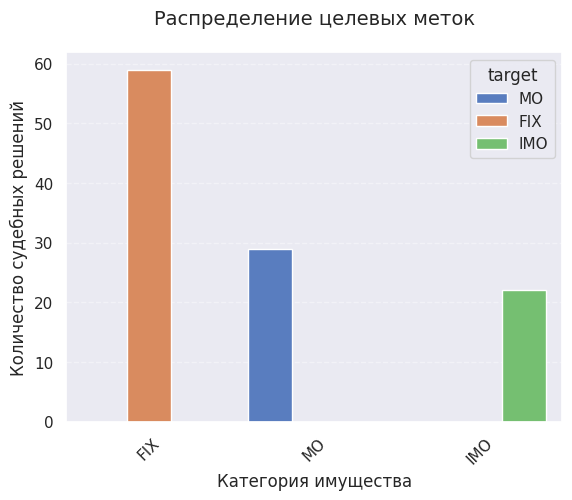

In [10]:
sns.countplot(
    data=df_real_estate,
    x='target',
    hue='target',
    order=df_real_estate['target'].value_counts().index,
    #palette=colors  # <-- Подключаем палитру
)
plt.title('Распределение целевых меток', fontsize=14, pad=20)
plt.xlabel('Категория имущества', fontsize=12)
plt.ylabel('Количество судебных решений', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)  # Сетка для удобства
plt.show()

In [11]:
print("Распределение целевых меток:")
print(df_real_estate['target'].value_counts(normalize=True).round(2))

Распределение целевых меток:
target
FIX    0.54
MO     0.26
IMO    0.20
Name: proportion, dtype: float64


В данных присутствует дисбаланс классов, учтем это при разделении данных на обучающую и тестовую выборки

**Преобразуем даты принятия судебных решений в формат `datetime` и создадим новый столбец, соответствующий году принятия решения**

In [12]:
df_real_estate['decision_date'] = pd.to_datetime(df_real_estate['decision_date'])
df_real_estate['year'] = df_real_estate['decision_date'].dt.year

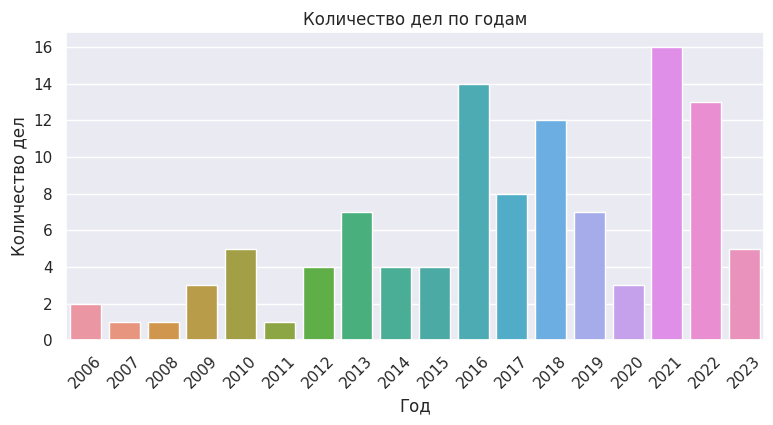

In [13]:
plt.figure(figsize=(9, 4))
sns.countplot(data=df_real_estate, x='year')
plt.title('Количество дел по годам')
plt.xlabel('Год')
plt.ylabel('Количество дел')
plt.xticks(rotation=45)
plt.show()

**Видим, что большая часть данных представлена, начиная с 2016 года по 2023. Актуальность вопроса, судя по всему, растет**

<Figure size 900x400 with 0 Axes>

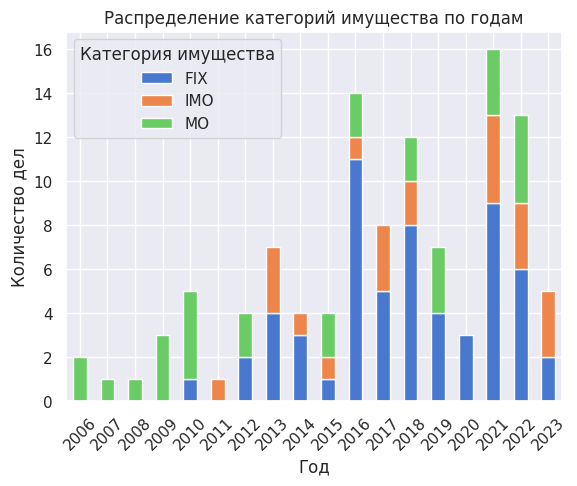

In [14]:
plt.figure(figsize=(9, 4))
df_real_estate.groupby(['year', 'target']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Распределение категорий имущества по годам')
plt.xlabel('Год')
plt.ylabel('Количество дел')
plt.xticks(rotation=45)
plt.legend(title='Категория имущества')
plt.show()

**Отметим:**

1. Проблематика категории `FIX` появляется только в 2010 году.
2. В последующие годы значимость данной категории в судебных спорах растет.

### EDA текстовых данных: до очистки

In [15]:
df_real_estate['text_length'] = df_real_estate['text'].apply(len)
df_real_estate['word_count'] = df_real_estate['text'].apply(lambda x: len(x.split()))

print("\nСтатистика по длине текста и количеству 'слов':")
print(df_real_estate[['text_length', 'word_count']].describe())


Статистика по длине текста и количеству 'слов':
        text_length   word_count
count    110.000000   110.000000
mean   11363.254545  1383.481818
std     7551.322586   933.379799
min     2212.000000   271.000000
25%     5795.750000   688.250000
50%     7936.500000   949.500000
75%    16205.750000  1939.750000
max    32767.000000  4243.000000


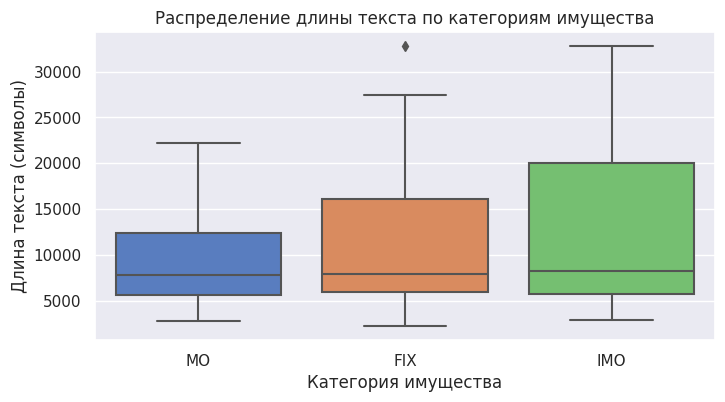

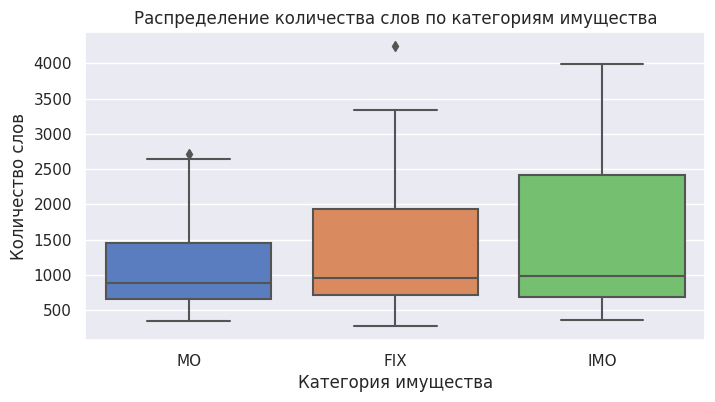

In [18]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_real_estate, x='target', y='text_length')
plt.title('Распределение длины текста по категориям имущества')
plt.xlabel('Категория имущества')
plt.ylabel('Длина текста (символы)')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_real_estate, x='target', y='word_count')
plt.title('Распределение количества слов по категориям имущества')
plt.xlabel('Категория имущества')
plt.ylabel('Количество слов')
plt.show()

**Отметим**:

1. Выборка содержит тексты разных длин, которые значительно варьируются от 271 до 4243 слова, при медианном значении в 949 слов и др. последовательностей. Юридические тексты судебных постановлений, как правило, содержат много "шума" (процессуальные детали, цитаты законов, канцлерские обороты, избыточные уточнения и т.д.). Объем этого "шума", с одной стороны, превосходит объем информационного "шума" в обычных текстах. С другой стороны, ссылки на некоторые статьи могут быть значимыми для классификации объектов.
2. При этом, полагаю, абсолютное значение объема информационного "шума" является примерно одинаковым для разных судебных постановлений: типовые формулировки в преамбуле, резолютивной части актов. Стало быть, тексты короче 3 тыс. символов могут быть краткими определениями или решениями без подробной аргументации. 

---
Однако мы не будем удалять данные, так как и и так критически мало, постараемся на этапе обработки текстов:
- помимо классического набора стоп-слов удалить малозначимые юридические слова;
- отобрать важные признаки на этапе векторизации текстов.

In [45]:
# Анализ наиболее частотных слов
def get_top_words(text_series, n=20):
    words = []
    for text in text_series:
        words.extend(re.findall(r'\b[А-Яа-я]{4,}\b', text.lower()))
    return Counter(words).most_common(n)

for target in df_real_estate['target'].unique():
    print(f"\nТоп-20 слов для категории {target}:")
    words = get_top_words(df_real_estate[df_real_estate['target'] == target]['text'])
    for word, count in words:
        print(f"{word}: {count}")


Топ-20 слов для категории MO:
суда: 477
российской: 450
федерации: 450
арбитражного: 321
права: 224
кодекса: 220
статьи: 198
собственности: 170
верховного: 145
инстанции: 121
процессуального: 120
дела: 119
далее: 115
имущество: 115
недвижимости: 109
округа: 106
части: 103
объект: 103
кассационной: 101
имущества: 101

Топ-20 слов для категории FIX:
российской: 1107
федерации: 1103
суда: 1055
арбитражного: 667
права: 666
кодекса: 497
собственности: 431
статьи: 423
верховного: 408
земельного: 365
участка: 346
процессуального: 288
далее: 264
кассационной: 255
объект: 254
делу: 252
объекта: 247
дела: 247
гражданского: 237
регистрации: 236

Топ-20 слов для категории IMO:
российской: 397
федерации: 397
суда: 387
арбитражного: 209
права: 200
строительства: 181
статьи: 161
недвижимости: 158
кодекса: 156
государственной: 147
объекта: 145
верховного: 134
дела: 128
москвы: 121
объект: 120
участка: 105
земельного: 103
собственности: 98
далее: 96
кассационной: 96


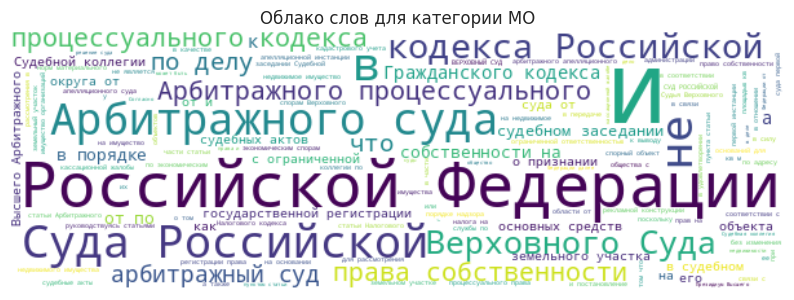

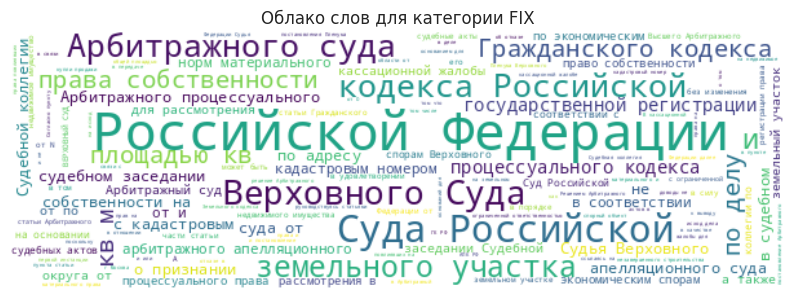

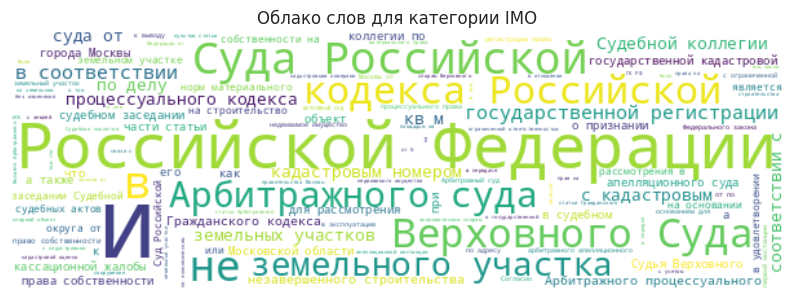

In [20]:
# Визуализация слов по категориям
for target in df_real_estate['target'].unique():
    text = ' '.join(df_real_estate[df_real_estate['target'] == target]['text'])
    wordcloud = WordCloud(width=600, height=200, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для категории {target}')
    plt.axis('off')
    plt.show()

**Видим, что наши наблюдения подтвердились: наиболее частотные слова, как правило - типовые словосочетания и термины, которые, очевидно, встречаются во всех судебных актах, и соответственно не несут значимой информации**

### Предобработка текстов

#### Лемматизация и очистка текстов

In [7]:
df_processed = df_real_estate.copy()

In [6]:
morph = pymorphy3.MorphAnalyzer()
word = "НЕдвижимого"
parsed = morph.parse(word)[0]  # разбираем слово
lemma = parsed.normal_form      # получаем нормальную форму

print(f"Исходное: {word} → Лемматизация: {lemma}")

Исходное: НЕдвижимого → Лемматизация: недвижимый


In [8]:
def lemmatize_text(text):
    text = re.sub(r'\s+', ' ', text).strip() # удаляем все лишние пробелы
    words = text.split()  # простейший сплит по пробелам 
    lemmas = []
    for word in words:
        parsed = morph.parse(word)[0]
        lemmas.append(parsed.normal_form)
    return " ".join(lemmas)

# Тестируем на примере
sample_text = "Следовательно, разрешение на ввод объекта в эксплуатацию удостоверяет также и возведение фундамента недвижимого объекта в полном объеме в соответствии с проектной документацией"
lemmatized = lemmatize_text(sample_text)
print("ДО:", sample_text)
print("ПОСЛЕ:", lemmatized)

ДО: Следовательно, разрешение на ввод объекта в эксплуатацию удостоверяет также и возведение фундамента недвижимого объекта в полном объеме в соответствии с проектной документацией
ПОСЛЕ: следовательно, разрешение на ввод объект в эксплуатация удостоверять также и возведение фундамент недвижимый объект в полный объём в соответствие с проектный документация


In [15]:
sample_text = '''Как указано в пункте 4.1 постановления Конституционного Суда Российской Федерации
от 22.06.2017 №16-П "По делу о проверке конституционности положения пункта 1 статьи 302 ГК РФ'''
lemmatized = lemmatize_text(sample_text)
print("ДО:", sample_text)
print("ПОСЛЕ:", lemmatized)

ДО: Как указано в пункте 4.1 постановления Конституционного Суда Российской Федерации
от 22.06.2017 №16-П "По делу о проверке конституционности положения пункта 1 статьи 302 ГК РФ
ПОСЛЕ: как указать в пункт 4.1 постановление конституционный суд российский федерация от 22.06.2017 №16-п "по дело о проверка конституционность положение пункт 1 статья 302 гк рф


**Загрузим заранее подготовленный список стоп-слов для русского языка, расширив его также юридической лексикой, которую будем считать для данной задачи неинформативной**

In [9]:
legal_stopwords = [
    "суд", "судья", "судебный", "верховный", "дело",
    "федеральный", "гражданский", "жалоба", "федерации",
    "являться", "далее", "рассмотрение", "указанный",
    "решение", "постановление", "определение", "округ", 'основание', 'отношение', 'n',
    "установил", "постановил", "определил", "норма", 
    "российский", "федерация", "экономический", "заседание",
    "москва", "кассационный", "апелляционный", "первый", "второй", "рф",
    "инстанция", "процессуальный", "арбитражный", "исковой", "иск",
    "год", "месяц", "январь", "февраль", "март", "апрель", "май", "июнь",
    "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"
]

In [10]:
with open('/kaggle/input/rus-stopwords/rus_stopwords.txt', 'r', encoding='utf-8') as f:
    sw = f.read().split('\n') + legal_stopwords
    sw = sw[10:] # цифры в юидичесикх текстах могут быть информативны

sw[:10]

['а', 'ах', 'б', 'без', 'безо', 'более', 'больше', 'будем', 'будет', 'будете']

In [11]:
len(sw)

508

In [12]:
def clean_text(text, custom_stopwords=None):
    """
    Очистка текста:
    1. Лемматизация всего текста
    2. Удаление пунктуации и спецсимволов (кроме "/" для статей)
    3. Сохранение номеров статей и пунктов
    4. Удаление всех цифр, кроме номеров статей/пунктов
    5. Удаление кастомных стоп-слов

    Параметры:
    text - исходный текст
    custom_stopwords - список стоп-слов для удаления
    """
    if custom_stopwords is None:
        custom_stopwords = set()

    # 1. Удаление номеров дел

    # text = re.sub(r'\b[А-Я]\d{2}-\d{2,5}/\d{4}\b', '', text)  # А40-12345/2020
    # text = re.sub(r'\b\d{3}-[А-Я]{2}\d{2}-\d{5}\b', '', text)  # 304-ЭС15-11476
    # 1. Удаление всех номеров (универсальный паттерн)
    text = re.sub(r'(№|\bномер\b)\s*[^\s]+', ' ', text)
    text = re.sub(r'\b\d+[-/]\d+([-/]\d+)*\b', ' ', text)  # Дополнительно удаляем цифровые коды
    text = re.sub('\n', ' ', text)
    
    # 1. Лемматизация всего текста
    text = lemmatize_text(text)
    # 3. Удаление пунктуации и спецсимволов (кроме "/" для статей)
    punct = r'[!№"#$%&\'()*+,.:;<=>?@[\\\]^_`{|}~„“«»†*\—–‘’\n\r\t]'
    text = re.sub(punct, ' ', text)
    # 4. Обработка номеров статей и пунктов
    # Объединяем в единые токены после лемматизации
    text = re.sub(r'(ст|статья)\s(\d+)', r'статья_\2', text)
    text = re.sub(r'(п|пункт)\s(\d+)', r'пункт_\2', text)
    # 5. Удаление всех цифр, кроме номеров статей/пунктов
    text = re.sub(r'(?<!\w)(\d+)(?!\w)', '', text)
    # 6. Финальная очистка от ВСЕХ служебных символов
    text = re.sub(r'[^\w\s]', '', text)  # удаляем всё, кроме букв/цифр/подчеркиваний

    # 7. Удаление кастомных стоп-слов
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]
    return ' '.join(words)

In [24]:
# Тестируем на примере
sample_text = '''
Согласно пункту 1 статьи 130 ГК РФ к недвижимым вещам (недвижимое имущество, недвижимость) относятся земельные участки, '''
cleaned_text = clean_text(sample_text, custom_stopwords=sw)
print("ДО:", sample_text)
print("ПОСЛЕ:", cleaned_text)

ДО: 
Согласно пункту 1 статьи 130 ГК РФ к недвижимым вещам (недвижимое имущество, недвижимость) относятся земельные участки, 
ПОСЛЕ: согласно пункт_1 статья_130 гк недвижимый вещь недвижимый имущество недвижимость относиться земельный участки


In [25]:
sample_text = '''
Дело №4-В12-13
от 19 июня 2012 года
Судебная коллегия по гражданским делам Верховного Суда'''
cleaned_text = clean_text(sample_text, custom_stopwords=sw)
print("ДО:", sample_text)
print("ПОСЛЕ:", cleaned_text)

ДО: 
Дело №4-В12-13
от 19 июня 2012 года
Судебная коллегия по гражданским делам Верховного Суда
ПОСЛЕ: коллегия


In [26]:
sample_text = '''
В судебном заседании приняли участие представители: 
Росимущества - Носова О.Е. (доверенность от 12.01.2021), Рамазанов 
А.Р. (доверенность от 11.01.2021); общества «Фореста» - Федоринов А.А. (доверенность от 01.08.2022), 
Каинов Р.В. (доверенность от 01.08.2022).'''
cleaned_text = clean_text(sample_text, custom_stopwords=sw)
print("ДО:", sample_text)
print("ПОСЛЕ:", cleaned_text)

ДО: 
В судебном заседании приняли участие представители: 
Росимущества - Носова О.Е. (доверенность от 12.01.2021), Рамазанов 
А.Р. (доверенность от 11.01.2021); общества «Фореста» - Федоринов А.А. (доверенность от 01.08.2022), 
Каинов Р.В. (доверенность от 01.08.2022).
ПОСЛЕ: принять участие представители росимущество носов доверенность рамазан доверенность общество фореста федорин доверенность каин доверенность


In [27]:
sample_text = '''
Росимущество обратилось в Арбитражный суд Московской области  с иском к обществу о признании 
распределительного газопровода среднего давления, назначение: газоснабжение, протяженностью 455 м, 
инв. № 178:057-9401, лит. 12Л, кадастровый номер 0-50-96/099/2012-054 (свидетельство о регистрации 
права серия 50-АД № 893493) и распределительного газопровода среднего давления, назначение: газоснабжение, 
протяженностью 867 м, инв. № 178:057-9401, лит. 12Л, кадастровый номер 50-50-96/099/2012-052 
(свидетельство о регистрации права серия 50-АД № 893492)'''
cleaned_text = clean_text(sample_text, custom_stopwords=sw)
print("ДО:", sample_text)
print("ПОСЛЕ:", cleaned_text)

ДО: 
Росимущество обратилось в Арбитражный суд Московской области  с иском к обществу о признании 
распределительного газопровода среднего давления, назначение: газоснабжение, протяженностью 455 м, 
инв. № 178:057-9401, лит. 12Л, кадастровый номер 0-50-96/099/2012-054 (свидетельство о регистрации 
права серия 50-АД № 893493) и распределительного газопровода среднего давления, назначение: газоснабжение, 
протяженностью 867 м, инв. № 178:057-9401, лит. 12Л, кадастровый номер 50-50-96/099/2012-052 
(свидетельство о регистрации права серия 50-АД № 893492)
ПОСЛЕ: росимущество обратиться московский область общество признание распределительный газопровод среднее давления назначение газоснабжение протяжённость инв лит 12л кадастровый свидетельство регистрация право серия ад распределительный газопровод среднее давления назначение газоснабжение протяжённость инв лит 12л кадастровый свидетельство регистрация право серия ад


In [28]:
sample_text = '''
Грачевой И.Л., судей Золотовой Е.Н. и Чучуновой Н.С.,  рассмотрела в открытом судебном заседании дело № А27-18141/2014 федеральный суда
'''
cleaned_text = clean_text(sample_text, custom_stopwords=sw)
print("ДО:", sample_text)
print("ПОСЛЕ:", cleaned_text)

ДО: 
Грачевой И.Л., судей Золотовой Е.Н. и Чучуновой Н.С.,  рассмотрела в открытом судебном заседании дело № А27-18141/2014 федеральный суда

ПОСЛЕ: грачёв золотов чучуновый рассмотреть открытый


In [13]:
df_processed['cleaned_text'] = df_processed['text'].progress_apply(
    lambda x: clean_text(x, custom_stopwords=sw)
)

  0%|          | 0/110 [00:00<?, ?it/s]

In [30]:
df_processed[['text', 'cleaned_text']].sample(1)

,text,cleaned_text
46,"ВЕРХОВНЫЙ СУД \nРОССИЙСКОЙ ФЕДЕРАЦИИ \n \n№ 308-ЭС20-23222 \n \nОПРЕДЕЛЕНИЕ \n \n \nг. Москва 17.05.2021 \nДело № А32-56709/2019 \n \nРезолютивная часть определения объявлена 12.05.2021 \nПолный текст определения изготовлен 17.05.2021 \n \n Судебная коллегия по экономическим спорам Верховного Суда Российской Федерации в составе: председательствующего судьи Завьяловой Т.В., судей Антоновой М.К., Тютина Д.В. рассмотрела в открытом судебном заседании дело по кассационной жалобе общества с ограниченной ответственностью «Юг-Новый Век» на решение Арбитражного суда Краснодарского края от 11.03.2020 по делу № А32-56709/2019, постановление Пятнадцатого арбитражного апелляционного суда от 03.07.2020 и постановление Арбитражного суда Северо-Кавказского округа от 03.11.2020 по тому же делу по заявлению общества с ограниченной ответственностью «Юг-Новый Век» (далее – общество, заявитель, налогоплательщик) о признании недействительным решения Межрайонной инспекции Федеральной налого...",резолютивный часть объявить полный текст изготовить коллегия спор составе председательствовать завьялов антонов тютина рассмотреть открытый общество ограниченный ответственность югновый век краснодарский край пятнадцатый северокавказский заявление общество ограниченный ответственность югновый век общество заявитель налогоплательщик признание недействительный межрайонный инспекция налоговый служба краснодарский край часть доначисление налог имущество организация сумма рубль сумма рубль годы начисление рубль пеня привлечение налоговый ответственность вид взыскание рубль копейка штрафа принять участие представители общество ограниченный ответственность югновый век первушин межрайонный инспекция налоговый служба краснодарский край безруков денисаев захаров полозок заслушать доклад завьялов выслушать объяснение представитель участвовать лиц коллегия спор установила межрайонный инспекция налоговый служба краснодарский край инспекция налоговый орган общество ограниченный ответственность ю...


In [46]:
for target in df_processed['target'].unique():
    print(f"\nТоп-20 слов для категории {target}:")
    words = get_top_words(df_processed[df_processed['target'] == target]['cleaned_text'])
    for word, count in words:
        print(f"{word}: {count}")


Топ-20 слов для категории MO:
объект: 328
право: 313
кодекс: 205
общество: 199
имущество: 176
земельный: 161
собственность: 159
налоговый: 142
часть: 133
государственный: 131
недвижимый: 126
участок: 116
спорный: 109
требование: 100
закон: 97
коллегия: 95
регистрация: 94
здание: 90
нарушение: 87
вывод: 85

Топ-20 слов для категории FIX:
право: 924
объект: 737
земельный: 727
общество: 508
участок: 483
кодекс: 454
собственность: 437
государственный: 379
недвижимый: 325
имущество: 321
часть: 294
спорный: 287
договор: 281
кадастровый: 272
площадь: 249
регистрация: 235
требование: 235
коллегия: 232
расположить: 222
нарушение: 218

Топ-20 слов для категории IMO:
объект: 403
земельный: 300
государственный: 275
право: 275
кадастровый: 229
участок: 227
общество: 221
строительство: 211
кодекс: 153
часть: 127
спорный: 125
закон: 108
собственность: 99
имущество: 98
коллегия: 97
номер: 96
требование: 95
недвижимый: 94
договор: 93
недвижимости: 92


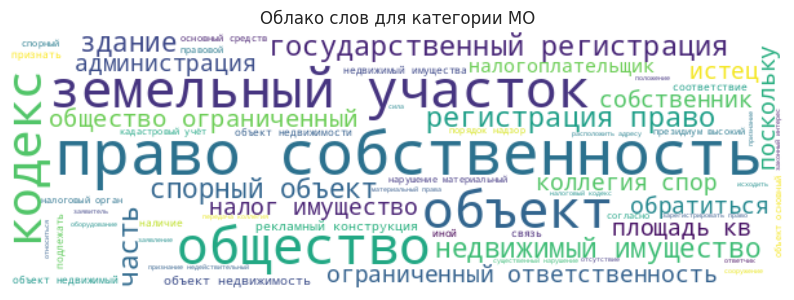

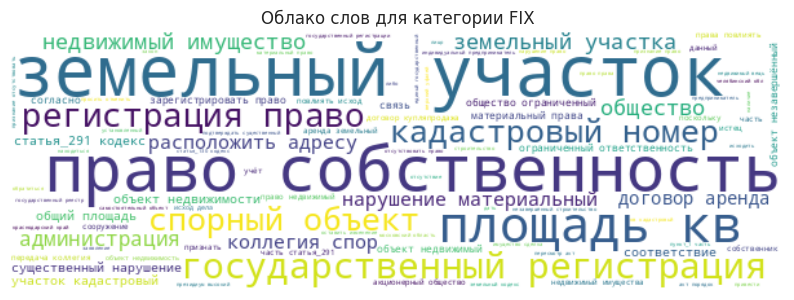

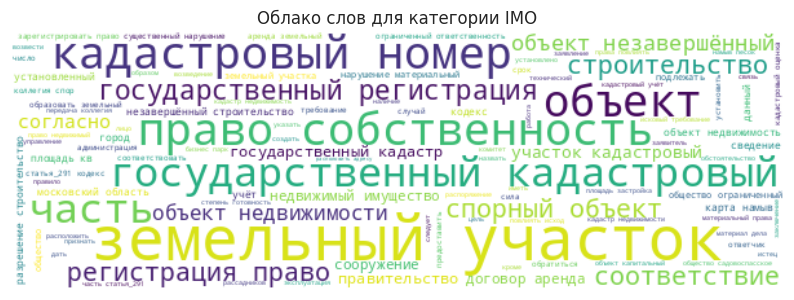

In [47]:
# Визуализация слов по категориям
for target in df_processed['target'].unique():
    text = ' '.join(df_processed[df_processed['target'] == target]['cleaned_text'])
    wordcloud = WordCloud(width=600, height=200, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для категории {target}')
    plt.axis('off')
    plt.show()

Выведем статистики после обработки

In [48]:
df_processed['text_length'] = df_processed['cleaned_text'].apply(len)
df_processed['word_count'] = df_processed['cleaned_text'].apply(lambda x: len(x.split()))

print("\nСтатистика по длине текста и количеству 'слов':")
print(df_processed[['text_length', 'word_count']].describe())


Статистика по длине текста и количеству 'слов':
        text_length   word_count
count    110.000000   110.000000
mean    7209.945455   751.081818
std     5326.298759   555.581473
min     1207.000000   138.000000
25%     3023.750000   319.500000
50%     4775.000000   504.000000
75%    10720.500000  1118.750000
max    22344.000000  2494.000000


**Видим проблематику именно сферы недвижимости. При этом отметим, что наиболее частые слова пересекаются по всем категориям.**

В заключение посмотрим на **самые редкие слова**

In [49]:
def get_rare_words(df, text_column='cleaned_text', top_n=20):

    # Собираем все слова из всех текстов
    all_words = []
    for text in df[text_column]:
        if isinstance(text, str):
            all_words.extend(text.split())
    word_counts = Counter(all_words)
    # Получаем самые редкие слова (встречающиеся 1-2 раза)
    rare_words = [(word, count) for word, count in word_counts.items() if count <= 2]
    # Сортируем по частоте (от самых редких)
    rare_words_sorted = sorted(rare_words, key=lambda x: x[1])
    # Берем топ-N самых редких
    top_rare = rare_words_sorted[:top_n]
    # Создаем DataFrame для наглядности
    rare_df = pd.DataFrame(top_rare, columns=['Слово', 'Частота'])
    return rare_df
# Применяем функцию к нашему датасету
rare_words_df = get_rare_words(df_processed, top_n=2256)
# Выводим результат
print(f"Топ-20 самых редких слов:")
display(rare_words_df)

Топ-20 самых редких слов:


,Слово,Частота
0,плате,1
1,необоснованность,1
2,явились,1
3,промышленнофинансовый,1
4,ленина,1
...,...,...
2251,попова,1
2252,балаковский,1
2253,усиление,1
2254,вертикальный,1


**Самые редкие и самые частые слова отфильтруем на этапе TF-IDF-векторизации**

### Анализ TF-IDF значимости слов во всем корпусе
при непосредственном обучении fit_transform применим только к тренировочной выборке, дабы не допустить утечки данных

In [31]:
tfidf_all = TfidfVectorizer(ngram_range=(1, 2),  # Униграммы + биграммы
                            min_df=5, # Игнорировать слова в <5 документах
                            max_df=0.85, # Игнорировать слова в >85% документов
                            norm=None) # Отключаем L2 нормализацию

X_all_tfidf = tfidf_all.fit_transform(df_processed["cleaned_text"])

In [32]:
# Топ-10 самых значимых слов (по среднему TF-IDF)
mean_tfidf = X_all_tfidf.mean(axis=0).A1
top_words = sorted(zip(tfidf_all.get_feature_names_out(), mean_tfidf), key=lambda x: -x[1])[:15]
print("Топ-10 значимых слов во всей выборке:")
for w in top_words:
  print(w)

Топ-10 значимых слов во всей выборке:
('земельный', 14.337038519695275)
('общество', 11.094501920743836)
('участок', 10.759506654333874)
('государственный', 9.297332717524935)
('земельный участок', 9.180922966737917)
('собственность', 7.930473809235311)
('кадастровый', 7.484162131910996)
('налоговый', 7.387308318905169)
('право собственность', 6.990027734865638)
('договор', 6.2086220642315375)
('строительство', 6.146597711036595)
('регистрация', 5.892459048220114)
('закон', 5.139151936551465)
('предприниматель', 5.009478521105614)
('площадь', 4.9493758553442015)


Топ-10 слов выглядят релевантно для сферы недвижимости

## Обучение моделей RandomForestClassifier и LGBMClassifier на tf-idf векторах

### RandomForestClassifier

**Подготовка данных (TF-IDF + Train/Test Split)**

In [14]:
# Разделяем данные на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    df_processed["cleaned_text"],  # Очищенные тексты
    df_processed["target"],         # Метки классов
    test_size=0.2,
    random_state=42,
    stratify=df_processed["target"]  # Стратификация для баланса классов
)

In [22]:
X_train.shape

(88,)

In [23]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=sw,
        min_df=5,
        max_df=0.85,
        norm=None
    )),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

In [35]:
params = {
    # Параметры TF-IDF
    'tfidf__min_df': [7],              # Минимальная частота термина в документах
    'tfidf__max_df': [0.9],       # Максимальная частота термина (исключение стоп-слов)
    'tfidf__max_features': [2000],  # Ограничение количества признаков    
    # Параметры RandomForest
    'clf__n_estimators': [200, 190, 210],   # Количество деревьев
    'clf__max_depth': [4, 5],      # Максимальная глубина дерева
    'clf__min_samples_split': [5],   # Минимальное число samples для разделения
    'clf__min_samples_leaf': [4],     # Минимальное число samples в листе
    'clf__criterion': ['gini', 'entropy'],  # Критерий разделения
}

In [36]:
# Настройка GridSearchCV
grid = GridSearchCV(
    pipeline,
    params,
    cv=3,
    scoring='f1_weighted',  # Учитывает дисбаланс классов
    n_jobs=-1,
    verbose=2  # Подробный вывод прогресса
)

In [37]:
print("Начало подбора параметров...")
grid.fit(X_train, y_train)

Начало подбора параметров...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.85, min_df=5,
                                                        ngram_range=(1, 2),
                                                        norm=None,
                                                        stop_words=['а', 'ах',
                                                                    'б', 'без',
                                                                    'безо',
                                                                    'более',
                                                                    'больше',
                                                                    'будем',
                                                                    'будет',
                                                                    'будете',
                                                                    'будешь',
                                                                    'будто',
                                                                    'буду',
                                                                    'будут',
                                                                    'будучи',
                                                                    'будь',
                                                                    'будьте',
                                                                    'бы', 'был',
                                                                    'была',
                                                                    'были',
                                                                    'было',
                                                                    'быть', 'в',
                                                                    'вам',
                                                                    'вами',
                                                                    'вас',
                                                                    'ваш',
                                                                    'ваше',
                                                                    'вдруг', ...])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [4, 5], 'clf__min_samples_leaf': [4],
                         'clf__min_samples_split': [5],
                         'clf__n_estimators': [200, 190, 210],
                         'tfidf__max_df': [0.9], 'tfidf__max_features': [2000],
                         'tfidf__min_df': [7]},
             scoring='f1_weighted', verbose=2)

In [38]:
# Сохранение лучшей модели
best_model = grid.best_estimator_
joblib.dump(best_model, 'best_rf_model.joblib')

['best_rf_model.joblib']

In [39]:
print("\nЛучшие параметры:")
print(grid.best_params_)


Лучшие параметры:
{'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_df': 0.9, 'tfidf__max_features': 2000, 'tfidf__min_df': 7}


In [40]:
y_pred = best_model.predict(X_test)
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Отчет классификации:
              precision    recall  f1-score   support

         FIX       0.79      0.92      0.85        12
         IMO       1.00      0.50      0.67         4
          MO       0.83      0.83      0.83         6

    accuracy                           0.82        22
   macro avg       0.87      0.75      0.78        22
weighted avg       0.84      0.82      0.81        22

Confusion Matrix:
 [[11  0  1]
 [ 2  2  0]
 [ 1  0  5]]


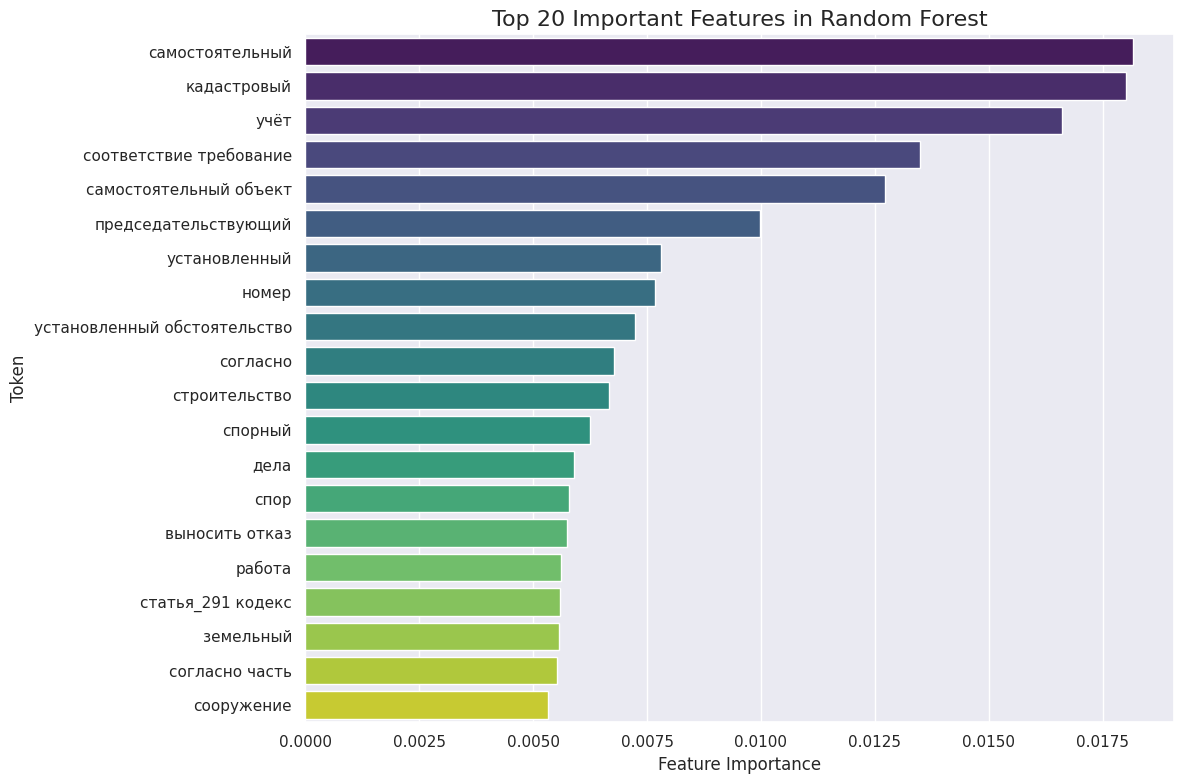

In [42]:
# Получаем названия признаков из TF-IDF
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Получаем важность признаков из RF
importances = best_model.named_steps['clf'].feature_importances_

# Сортируем по важности
sorted_idx = importances.argsort()[::-1][:20]

plt.figure(figsize=(12, 8))
sns.barplot(
    x=importances[sorted_idx],
    y=feature_names[sorted_idx],
    palette="viridis"
)
plt.title("Top 20 Important Features in Random Forest", fontsize=16)
plt.xlabel("Feature Importance")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

**Отметим**:

1. Среди признаков лидируют фичи, связанные с самостоятельностью объектов: действительно, данный признак позволяет отличить наиболее популярную категорию `FIX` в датасете от остальных категорий: если вещь не может самостоятельно учавствовать в обороте, она просто не является вещью, но ее улучшением.
2. Присустствуют признаки, связанные с процессуальными статьями законов, а также судебной процедурой (*председательствующий, спор, спорный, выносить отказ, дела*).
3. Специальная лексика, сответствующая домену: земельный, сооружение, строительство, кадастровый.

---

**Интерпретация результатов**

Модель, в целом, демонтстрирует адекватность: из 22 тестовых примеров (12 - `FIX`, 4 - `IMO`, 6 - `MO`):

1. Модель правильно предсказала для `FIX` в 11 из 12 случаях.
1 ошибка: один пример класса `FIX` предсказан как класс `MO`.

2. Модель правильно предсказала для `IMO` в 2 из 4 случаев.
Также допущено 2 ошибки в пользу наиболее популярного класса `FIX`, что понятно, учитывая, что улучшение недвижимого имущества является его частью, хоть и не является самостоятельной вещью: грань тонка!

3. Модель правильно предсказала для `MO` в 5 из 6 случаев.

### LGBMClassifier

In [47]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=sw,
        min_df=7,
        max_df=0.9,
        norm=None
    )),
    ('clf', LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1  # Использование всех ядер
    ))
])

In [48]:
# 2. Параметры для GridSearch
params = {
    # Параметры TF-IDF (аналогично вашему примеру)
    'tfidf__min_df': [5],              
    'tfidf__max_df': [0.85],     
    'tfidf__max_features': [2000],
    
    # Параметры LGBMClassifier
    'clf__n_estimators': [200],
    'clf__max_depth': [5, 6],  # -1 означает нет ограничения
    'clf__learning_rate': [0.1, 0.05],
    'clf__num_leaves': [20],  # Максимальное количество листьев
    # 'clf__min_child_samples': [10],
    'clf__subsample': [0.8, 1]  # Доля случайных samples для каждого дерева
}
# 3. Настройка GridSearchCV
grid = GridSearchCV(
    pipeline,
    params,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

In [49]:
print("Начало подбора параметров для LGBM...")
grid.fit(X_train, y_train)

Начало подбора параметров для LGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 527
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=7,
                                                        ngram_range=(1, 2),
                                                        norm=None,
                                                        stop_words=['а', 'ах',
                                                                    'б', 'без',
                                                                    'безо',
                                                                    'более',
                                                                    'больше',
                                                                    'будем',
                                                                    'будет',
                                                                    'будете',
                                                                    'будешь',
                                                                    'будто',
                                                                    'буду',
                                                                    'будут',
                                                                    'будучи',
                                                                    'будь',
                                                                    'будьте',
                                                                    'бы', 'был',
                                                                    'была',
                                                                    'были',
                                                                    'было',
                                                                    'быть', 'в',
                                                                    'вам',
                                                                    'вами',
                                                                    'вас',
                                                                    'ваш',
                                                                    'ваше',
                                                                    'вдруг', ...])),
                                       ('clf',
                                        LGBMClassifier(class_weight='balanced',
                                                       n_jobs=-1,
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.1, 0.05],
                         'clf__max_depth': [5, 6], 'clf__n_estimators': [200],
                         'clf__num_leaves': [20], 'clf__subsample': [0.8, 1],
                         'tfidf__max_df': [0.85], 'tfidf__max_features': [2000],
                         'tfidf__min_df': [5]},
             scoring='f1_weighted', verbose=2)

In [50]:
# 4. Вывод результатов
best_model = grid.best_estimator_
print("\nЛучшие параметры:")
print(grid.best_params_)

y_pred = best_model.predict(X_test)
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Лучшие параметры:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__num_leaves': 20, 'clf__subsample': 0.8, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 5}

Отчет классификации:
              precision    recall  f1-score   support

         FIX       0.75      0.75      0.75        12
         IMO       0.25      0.25      0.25         4
          MO       0.83      0.83      0.83         6

    accuracy                           0.68        22
   macro avg       0.61      0.61      0.61        22
weighted avg       0.68      0.68      0.68        22

Confusion Matrix:
 [[9 2 1]
 [3 1 0]
 [0 1 5]]


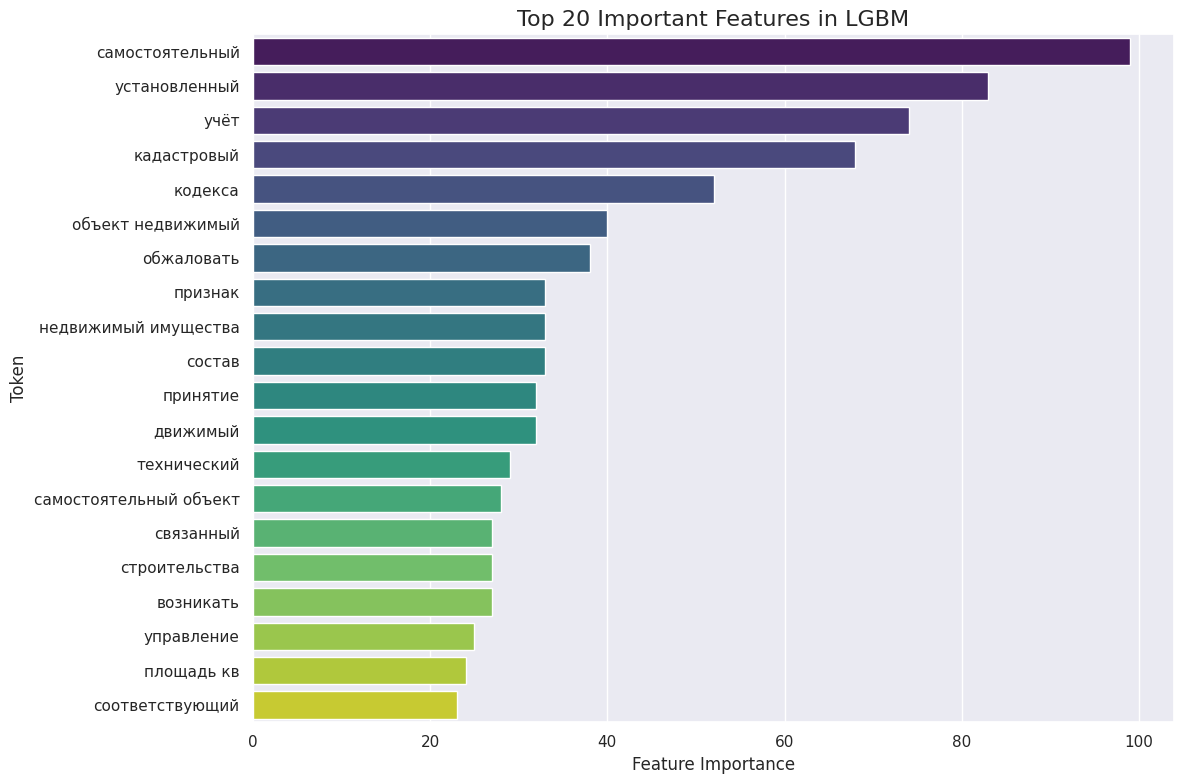

In [51]:
# Получаем названия признаков из TF-IDF
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Получаем важность признаков из LGBM
importances = best_model.named_steps['clf'].feature_importances_

# Сортируем по важности
sorted_idx = importances.argsort()[::-1][:20]

plt.figure(figsize=(12, 8))
sns.barplot(
    x=importances[sorted_idx],
    y=feature_names[sorted_idx],
    palette="viridis"
)
plt.title("Top 20 Important Features in LGBM", fontsize=16)
plt.xlabel("Feature Importance")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

**Отметим**:

1. Среди признаков также лидируют фичи, связанные с самостоятельностью объектов, однако словосочетание "самостоятельный объект" не попадает в топ-10.
2. Фактически отсутствуют признаки, связанные с процессуальными статьями законов, а также судебной процедурой.
3. Специальная лексика, сответствующая домену также присуствует + немного больше явно "шумовых" данных.

---

**Интерпретация результатов**

Модель также демонтстрирует адекватность: из 22 тестовых примеров (12 - `FIX`, 4 - `IMO`, 6 - `MO`):

1. Модель правильно предсказала для `FIX` в 9 из 12 случаях.

2. Модель хуже спарвляется с `IMO`: только в 1 из 4 случаев.

3. Модель правильно предсказала для `MO` в 5 из 6 случаев.


**С учетом скорости обучения, интерпретируемости и большей простоты модели первенство у `RandomForestClassifier`**

## Обучение модели RandomForestClassifier и LGBMClassifier на предобученных Glove-эмбеддингах от Navec с весами tf-idf

### Установим необходимые библиотеки

In [15]:
#!pip uninstall -y gensim scipy numpy
#!pip install scipy==1.10.1 numpy==1.23.5
!pip install gensim

In [16]:
import gensim
from gensim.models import *
from gensim import corpora, models
from gensim import similarities
from gensim.models import KeyedVectors

### Navec
---
Воспользуемся предобученными эмбеддингами от проекта `Natasha`:

- по сравнению с эмбеддингами от `RusVectores` модель `Navec` имеет существенно меньший размер (~50 мб), а также сопоставимое качество;
- размер словаря у данной модели меньше, однако у нас специализированная доменная область, поэтому количество != качество;
- архитектура `GloVe`, которая лежит в основе обучения модели `Navec`, лучше улавливает глобальные статистические закономерности, рассчитывая глобальную матрицу коллокаций с информацией о совместной встречаемости слов по всему корпусу текстов;
- учитывая, что у нас специальная доменная область, для обработки OOV, возможно, также эффективно было бы использовать модели, имеющией архитектуру `FastText`; однако здесь также нет полной уверенности, учитывая, что предобученные эмбеддинги, навряд ли, встречались с последовательностями типа `пункт_101` + работаем с лемматизированными текстами: в данной задаче морфология не так важна.

In [17]:
!pip install navec
from navec import Navec

In [18]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar -O navec_news_v1_1B_250K_300d_100q.tar

--2025-04-14 11:02:18--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  34.8MB/s    in 0.7s    

2025-04-14 11:02:19 (34.8 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



**Загрузим эмбеддинги, обученные на новостных статьях**

In [19]:
navec = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')

In [20]:
# Собираем уникальные слова из всех текстов
all_words = set()
for text in df_processed["cleaned_text"]:
    words = text.split()  # Разбиваем текст на слова
    all_words.update(words)  # Добавляем в множество уникальных слов
print(f"Всего уникальных слов в датасете: {len(all_words)}")
print(f"Размер словаря Navec: {len(navec.vocab.words)}")  # Обратите внимание: navec.vocab вместо navec.key_to_index

Всего уникальных слов в датасете: 6019
Размер словаря Navec: 250002


In [21]:
# Проверка покрытия
covered_words = [word for word in all_words if word in navec.vocab.words]
print(f"Покрытие: {len(covered_words)}/{len(all_words)} ({len(covered_words)/len(all_words):.1%})")

Покрытие: 4775/6019 (79.3%)


**Видим, что размер словаря `OOV` (Out Of Vocabulary) составляет около 20%**

In [92]:
navec.vocab.words[:10]

['a', 'a-gps', 'a-ha', 'a-one', 'aa', 'aaa', 'aac', 'aacute', 'aad', 'aap']

In [40]:
# Фильтрация словаря перед передачей в TF-IDF
russian_vocab = [word for word in navec.vocab.words if 
                 any(cyrillic in word for cyrillic in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя')]

In [41]:
len(russian_vocab)

236720

In [22]:
# Замена всех 'ё' на 'е' в текстах
df_processed["cleaned_text"] = df_processed["cleaned_text"].apply(
    lambda text: re.sub(r'ё', 'е', text)
)

In [23]:
texts = [text.split() for text in df_processed["cleaned_text"]]

In [24]:
all_unique_words = set(word for text in texts for word in text)
total_unique_words = len(all_unique_words)

oov_unique_words = set(word for word in all_unique_words if word not in navec.vocab)
oov_unique_percentage = (len(oov_unique_words) / total_unique_words) * 100

print(f"Уникальных слов в датасете: {total_unique_words}")
print(f"Уникальных OOV слов: {len(oov_unique_words)} ({oov_unique_percentage:.2f}%)")

Уникальных слов в датасете: 6012
Уникальных OOV слов: 1220 (20.29%)


**Инициализация TF-IDF**

In [27]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    ngram_range=(1, 2),
    min_df=7,
    max_df=0.9,
    norm=None,
   # vocabulary=list(updated_embeddings.keys())  # Ограничение словарём эмбеддингов
)
# Обучение и преобразование train данных
X_train_tfidf = tfidf.fit_transform(X_train)  
# Преобразование test данных 
X_test_tfidf = tfidf.transform(X_test)
tfidf_vocab = tfidf.vocabulary_ # Сохраняем словарь

Так как при обучении классификатора помимо эмбеддингов будем использовать tfidf-веса, посчитаем размер `tfidf_vocab`, а также слов, присутствующих в `tfidf_vocab`, но отсутствующих в словаре `Navec` (`oov_in_tfidf`)

In [28]:
tfidf_vocab = set(tfidf_vocab.keys())
navec_vocab = set(navec.vocab.words)
oov_in_tfidf = [word for word in tfidf_vocab if word not in navec_vocab]
display(f"Размер словаря TF-IDF: {len(tfidf_vocab)}")
print(f"Уникальных OOV в TF-IDF: {len(oov_in_tfidf)}")

'Размер словаря TF-IDF: 1762'

Уникальных OOV в TF-IDF: 872


In [29]:
word_counts = Counter(word for text in df_processed["cleaned_text"] for word in text.split())
top_oov = [(word, word_counts[word]) for word in oov_in_tfidf]
top_oov.sort(key=lambda x: -x[1])
print("Топ-20 OOV в TF-IDF:", top_oov[:20])

Топ-20 OOV в TF-IDF: [('пункт_1', 260), ('статья_291', 201), ('исковый', 156), ('статья_130', 133), ('недействительный', 119), ('купляпродажа', 88), ('вещный', 77), ('пункт_2', 58), ('несоразмерный', 47), ('пункт_3', 46), ('пункт_38', 44), ('обязаний', 41), ('пункт_52', 40), ('инвентарный', 40), ('предназначить', 38), ('пункт_4', 37), ('статья_39', 36), ('статья_304', 36), ('статья_222', 32), ('чучуновый', 31)]


**Видим, что OOV-слова**:

- специальная юридическая лексика;
- склеенные спец. биграммы: пункты и статьи законов;
- имена собственные.

### Дообучение W2V-модели для OOV-words + линейное преобразование -->  GloVe (Navec)

<div style="border: 2px solid #9370DB; padding: 10px; border-radius: 5px; background-color: #F8F8FF;">
Учитывая поставленную задачу - использовать веса tf-idf на предобученных эмбеддингах для русского языка, мы вунуждены будем ограничиться размер словаря `tfidf_vocab`, который получился существенно меньше размера изначального словаря.

При этом около 50% слов являются OOV-словами, которые могут иметь существенное значение для качества решения поставленной задачи.

Использование для дообучения матрицы коллокаций на корпусе текстов модели с архитектурой Glove нецелесообразно вследствие недостаточности данных, а также трудоемкости реализации (в текущий момент в gensim отсутствуют рабочие и легко настраиваемые модули для инициализации и обучения моделей с соответствуюей архитектурой). 

**Будем использовать "костыль"**: 

1. Обучим на корпусе текстов, состоящих из списков униграмм и биграмм, находящихся `tfidf_vocab.`, эмбеддинги для OOV.
2. Так как w2v и GloVe (Navec) используют разные методы обучения, их векторы могут находиться в разных пространствах. Решение: выровнять пространства эмбеддингов с помощью линейного преобразования.
3. Создадим общий словарь, состоящий из нативных предобученных векторов и полученных векторов для OOV.
</div>

In [30]:
tfidf_list = list(tfidf_vocab)
len(tfidf_list)

1762

In [31]:
# Разделяем OOV на униграммы и биграммы
unigrams = [term for term in tfidf_list if ' ' not in term]
bigrams = [term for term in tfidf_list if ' ' in term]

# Преобразуем биграммы в формат "слово1_слово2"
processed_sentences = []
for sentence in [text.split() for text in df_processed["cleaned_text"]]:
    processed = []
    i = 0
    while i < len(sentence):
        # Проверяем текущее и следующее слово на биграмму
        if i < len(sentence)-1 and f"{sentence[i]} {sentence[i+1]}" in bigrams:
            processed.append(f"{sentence[i]} {sentence[i+1]}")
            i += 2
        else:
            processed.append(sentence[i])
            i += 1
    processed_sentences.append(processed)

In [32]:
len(processed_sentences) 

110

In [33]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f"Epoch {self.epoch}, Loss: {loss}")
        self.epoch += 1

loss_logger = LossLogger()

**Инициализируем модель Word2Vec**

- учитывая, что данные содержат много юридических терминов и устойчивых словосочетаний, исходим из предположения, что `CBOW` сможет лучше уловить усреднённый контекст таких конструкций, так как менее чувствителен к редким словам (поскольку использует усреднение контекста)

In [52]:
model = Word2Vec(
    vector_size=300,
    window=8,          # Увеличиваем стандарт размер "окна" для юридических конструкций
    min_count=7,
    workers=8,         
    sg=0,              # CBOW mode
    alpha=0.0025,      # Начальная скорость обучения
    min_alpha=0.0001,  # Минимальная скорость
    negative=5,       #  негативные примеры
    hs=0,              # Только negative sampling
    sample=1e-5,       # Порог частых слов
    cbow_mean=1        # Усреднение контекста
)
# Строим словарь для униграмм и биграмм
model.build_vocab(processed_sentences)

Epoch 0, Loss: 9549.1240234375
Epoch 1, Loss: 19369.638671875
Epoch 2, Loss: 29231.474609375
Epoch 3, Loss: 39313.109375
Epoch 4, Loss: 49502.0546875
Epoch 5, Loss: 54313.8046875
Epoch 6, Loss: 64099.8984375
Epoch 7, Loss: 68827.375
Epoch 8, Loss: 74070.6796875
Epoch 9, Loss: 84343.7578125


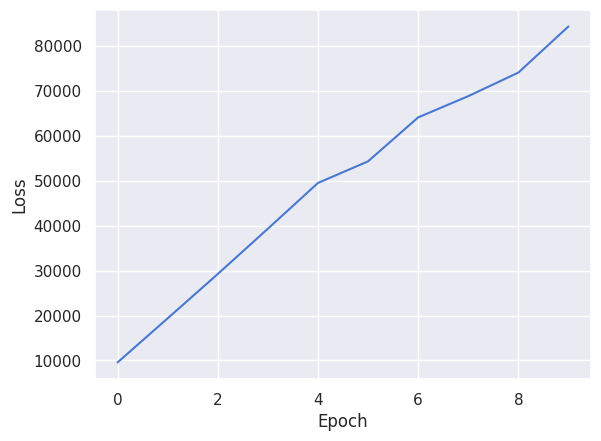

In [53]:
loss_logger = LossLogger()

model.train(
    processed_sentences,
    total_examples=len(processed_sentences),
    epochs=10,
    compute_loss=True,
    callbacks=[loss_logger]
)
plt.plot(loss_logger.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Loss растёт линейно, начиная с 4 эпохи немного замедляется

Нет резких скачков — обучение устойчивое

Очевидно, что не хватает данных

In [54]:
updated_embeddings = {}

# Добавляем вектора Navec как основной источник
for word in navec.vocab.words:
    updated_embeddings[word] = navec[word]

In [55]:
len(updated_embeddings)

250002

In [57]:
# Добавляем слова из CBOW с преобразованием
common_words = [w for w in model.wv.key_to_index if w in navec]
len(common_words)

1371

**Преобразуем матрицу векторов из w2v** 

1. Построим матрицы векторов для общих слов:

- X — векторы из Navec (shape = [n_common_words, dim]).

- Y — соответствующие векторы из w2v (shape = [n_common_words, dim]).

2. Обучим линейное преобразование (W), минимизирующее разницу между X и Y, через линейную регрессию (sklearn.linear_model.Ridge).

3. Применим преобразование к OOV-векторам w2v, общие векторы оставляем нативными, из Navec.

In [58]:
X = np.array([navec[w] for w in common_words])
Y = np.array([model.wv[w] for w in common_words])

In [59]:
# Нормируем векторы (L2-норма = 1)
X = X / np.linalg.norm(X, axis=1, keepdims=True)
Y = Y / np.linalg.norm(Y, axis=1, keepdims=True)
Y.shape

(1371, 300)

In [60]:
#Обучаем линейное преобразование (Ridge регрессия)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, fit_intercept=False, solver="svd")  # SVD для устойчивости
ridge.fit(X, Y)
# Получаем матрицу W (300×300)
W = ridge.coef_.T  # Транспонируем, чтобы было X @ W ≈ Y
W.shape

(300, 300)

In [61]:
# Функция для преобразования векторов
def align_vector(vec, W):
    return vec @ W

# Обработка всех слов модели
for word in model.wv.key_to_index:
    if word not in updated_embeddings:
        if ' ' in word:  # Биграмма
            word1, word2 = word.split()
            vectors = []
            for w in [word1, word2]:
                if w in navec:
                    vectors.append(navec[w])
                elif w in model.wv:
                    vectors.append(align_vector(model.wv[w], W))
            updated_embeddings[word] = np.mean(vectors, axis=0) if vectors else np.zeros(300)
        else:  # Униграмма
            updated_embeddings[word] = align_vector(model.wv[word], W) if word not in navec else navec[word]

In [62]:
len(updated_embeddings)

250795

In [65]:
# Проверка покрытия TFIDFVOCAB
found_unigrams = sum(1 for word in unigrams if word in updated_embeddings)
found_bigrams = sum(1 for phrase in bigrams if phrase in updated_embeddings)

print(f"\nПокрытие TFIDFVOCAB:")
print(f"Униграммы: {found_unigrams}/{len(unigrams)}")
print(f"Биграммы: {found_bigrams}/{len(bigrams)}")


Покрытие TFIDFVOCAB:
Униграммы: 922/942
Биграммы: 648/820


Видим, что около 190 слов и словосочетаний по каким-то причинам остались непокрытыми. 

In [66]:
print("\nПроверка биграмм:")
for bigram in bigrams[:5]:
    if bigram in updated_embeddings:
        print(f"\n{bigram}:")
        print(f"Размер вектора: {len(updated_embeddings[bigram])}")
        word1, word2 = bigram.split(' ')
        if word1 in navec and word2 in navec:
            sim1 = np.dot(updated_embeddings[bigram], navec[word1])
            sim2 = np.dot(updated_embeddings[bigram], navec[word2])
            print(f"Косинусная близость с '{word1}': {sim1:.2f}")
            print(f"Косинусная близость с '{word2}': {sim2:.2f}")


Проверка биграмм:

либо отказ:
Размер вектора: 300
Косинусная близость с 'либо': 20.60
Косинусная близость с 'отказ': 24.84

нарушить право:
Размер вектора: 300
Косинусная близость с 'нарушить': 25.01
Косинусная близость с 'право': 28.47

земельный участке:
Размер вектора: 300
Косинусная близость с 'земельный': 26.33
Косинусная близость с 'участке': 24.90

назначение невозможно:
Размер вектора: 300
Косинусная близость с 'назначение': 21.86
Косинусная близость с 'невозможно': 17.65

объект капитальный:
Размер вектора: 300
Косинусная близость с 'объект': 24.67
Косинусная близость с 'капитальный': 24.39


In [69]:
print("Ближайшие к 'недвижимое имущество':", model.wv.most_similar("недвижимый имущества", topn=10))

Ближайшие к 'недвижимое имущество': [('октября', 0.21378035843372345), ('несоразмерный ущерб', 0.1684228479862213), ('казань', 0.16414551436901093), ('определила', 0.1611931473016739), ('продать', 0.15872767567634583), ('дела достаточный', 0.1558932065963745), ('обстоятельство', 0.1545569896697998), ('заявитель', 0.15391001105308533), ('администрация', 0.15288223326206207), ('определять', 0.14924019575119019)]


**Напишем функцию, которая возвращает взвешенные эмбеддинги всех слов из `tfidfvocab`**

- также добавим ограничение на максимальное количество используемых эмбеддингов (*усреднение векторов для каждого текста в корпусе показало неудволетворительные результаты*);
- максимальное количество используемых эмбеддингов должно соответствовать top max весам tf-idf/

In [70]:
from scipy.sparse import hstack


In [71]:
def get_weighted_concat_embeddings(texts, tfidf_matrix, tfidf_vocab, max_words=None):
    """
    Возвращает конкатенированные взвешенные эмбеддинги всех слов.
    
    Параметры:
    - max_words: ограничение на количество слов 
    """
    features = []
    for i, text in enumerate(texts):
        words = text.split()
        weighted_embs = []
        
        # Собираем все допустимые слова с их весами
        word_weights = []
        for word in words:
            if word in updated_embeddings and word in tfidf_vocab:
                weight = tfidf_matrix[i, tfidf_vocab[word]]
                word_weights.append((word, weight))
        
        # Сортируем по весу и ограничиваем max_words при необходимости
        if max_words:
            word_weights.sort(key=lambda x: x[1], reverse=True)
            word_weights = word_weights[:max_words]
        
        # Конкатенируем взвешенные эмбеддинги
        concat_vec = np.concatenate(
            [updated_embeddings[w] * weight for w, weight in word_weights] or 
            [np.zeros(300)]  # fallback
        )
        
        features.append(concat_vec)
    
    return np.vstack(features)
# Пример использования:
X_train_emb = get_weighted_concat_embeddings(X_train, X_train_tfidf, tfidf.vocabulary_, max_words=7)
X_test_emb = get_weighted_concat_embeddings(X_test, X_test_tfidf, tfidf.vocabulary_, max_words=7)

In [75]:
print(f"Train shape: {X_train_emb.shape}")
print(f"Test shape: {X_test_emb.shape}")

Train shape: (88, 2100)
Test shape: (22, 2100)


### RandomForestClassifier на предобученных эмбеддингах с весами tf-idf

In [73]:
# 6. Обучение RandomForest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=7,
    random_state=42,
    class_weight='balanced'
)

In [74]:
rf.fit(X_train_emb, y_train)

# 7. Оценка модели
y_pred = rf.predict(X_test_emb)
print(classification_report(y_test, y_pred))
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

         FIX       0.59      0.83      0.69        12
         IMO       1.00      0.25      0.40         4
          MO       0.50      0.33      0.40         6

    accuracy                           0.59        22
   macro avg       0.70      0.47      0.50        22
weighted avg       0.64      0.59      0.56        22

Confusion Matrix:
 [[10  0  2]
 [ 3  1  0]
 [ 4  0  2]]


In [261]:
rf.fit(X_train_emb, y_train)

# 7. Оценка модели
y_pred = rf.predict(X_test_emb)
print(classification_report(y_test, y_pred))
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

         FIX       0.59      0.83      0.69        12
         IMO       1.00      0.25      0.40         4
          MO       0.50      0.33      0.40         6

    accuracy                           0.59        22
   macro avg       0.70      0.47      0.50        22
weighted avg       0.64      0.59      0.56        22

Confusion Matrix:
 [[10  0  2]
 [ 3  1  0]
 [ 4  0  2]]


In [211]:
X_train_emb = get_weighted_concat_embeddings(X_train, X_train_tfidf, tfidf.vocabulary_, max_words=7)
X_test_emb = get_weighted_concat_embeddings(X_test, X_test_tfidf, tfidf.vocabulary_, max_words=7)

In [76]:
from itertools import product
# Параметры для перебора
param_grid = {
    'max_words': [4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [200, 250, 300],
    'max_depth': [5, 6, 7],
    'min_samples_split': [3, 4, 2]
}
# Генерация всех комбинаций параметров
all_params = [dict(zip(param_grid.keys(), vals)) 
             for vals in product(*param_grid.values())]
# DataFrame для сохранения результатов
results = pd.DataFrame(columns=['max_words', 'n_estimators', 'max_depth','criterion', 
                              'min_samples_split', 'mean_f1', 'std_f1'])
pbar = tqdm(total=len(all_params), desc="Подбор параметров")

Подбор параметров:   0%|          | 0/189 [00:00<?, ?it/s]

In [77]:
best_score = -1
best_params = {}

for params in all_params:
    # 1. Подготовка данных
    X_train_emb = get_weighted_concat_embeddings(
        X_train, X_train_tfidf, tfidf.vocabulary_,
        max_words=params['max_words']
    )
    # Инициализация модели
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    # Кросс-валидация (5 фолдов)
    scores = cross_val_score(
        model, X_train_emb, y_train,
        cv=3, scoring='f1_weighted',
        n_jobs=-1
    )
    # Сохранение результатов
    mean_f1 = np.mean(scores)
    std_f1 = np.std(scores)
    
    results.loc[len(results)] = {
        **params,
        'mean_f1': mean_f1,
        'std_f1': std_f1
    }
    # Обновление лучших параметров
    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params.copy()
        best_params['mean_f1'] = mean_f1
        best_params['std_f1'] = std_f1
    pbar.update(1)
    pbar.set_postfix({'Лучший F1': f"{best_score:.3f}"})
pbar.close()

In [78]:
# Сортировка результатов
results = results.sort_values('mean_f1', ascending=False)
# Вывод лучших параметров
print("\nЛучшие параметры:")
print(pd.DataFrame([best_params]).T)



Лучшие параметры:
                            0
max_words            4.000000
n_estimators       200.000000
max_depth            7.000000
min_samples_split    2.000000
mean_f1              0.545146
std_f1               0.126510


In [301]:
# Обучение финальной модели на лучших параметрах
print("\nОбучение финальной модели...")
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

final_model.fit(
    get_weighted_concat_embeddings(
        X_train, X_train_tfidf, tfidf.vocabulary_,
        max_words=best_params['max_words']
    ),
    y_train
)

# Оценка на тестовых данных
X_test_emb = get_weighted_concat_embeddings(
    X_test, X_test_tfidf, tfidf.vocabulary_,
    max_words=best_params['max_words']
)

y_pred = final_model.predict(X_test_emb)
print("\nОтчет классификации на тестовых данных:")
print(classification_report(y_test, y_pred))
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Обучение финальной модели...

Отчет классификации на тестовых данных:
              precision    recall  f1-score   support

         FIX       0.60      0.75      0.67        12
         IMO       1.00      0.50      0.67         4
          MO       0.40      0.33      0.36         6

    accuracy                           0.59        22
   macro avg       0.67      0.53      0.57        22
weighted avg       0.62      0.59      0.58        22

Confusion Matrix:
 [[9 0 3]
 [2 2 0]
 [4 0 2]]


**Видим, что `RandomForestClassifier` на предобученных эмбеддингах хуже справился с задачей классификации, чем классификатор на фичах, являющихся чистыми tf-idf-весами**:

- Если для категории `IMO` выбранные фичи или архитектуры не дали значимого эффекта, то с разграничением категорий `MO` и `FIX` классификатор, обученных на "чистых" tfidf-признаках справился значительно лучше.

### LGBMClassifier на предобученных эмбеддингах с весами tf-idf

**Заново напишем функцию для получения взвешенных эмбеддиногов: получившиися vector stacks преобразуем в разреженную матрицу, которая хранит только ненулевые значения (`csr_matrix`)**

In [85]:
from scipy.sparse import csr_matrix

In [86]:
def get_weighted_concat_embeddings_lgbm(texts, tfidf_matrix, tfidf_vocab, embeddings, max_words=10):
    """
    Генерирует взвешенные конкатенированные эмбеддинги с ограничением по количеству слов 
    Параметры:
    texts - список текстов
    tfidf_matrix - разреженная матрица TF-IDF
    tfidf_vocab - словарь {слово: индекс} из TF-IDF
    embeddings - словарь эмбеддингов
    max_words - максимальное количество слов для конкатенации
    """
    # Подготовка весов TF-IDF для каждого документа
    tfidf_weights = []
    for i in range(tfidf_matrix.shape[0]):
        indices = tfidf_matrix[i].indices
        data = tfidf_matrix[i].data
        tfidf_weights.append({tfidf_vocab[idx]: weight for idx, weight in zip(indices, data)})
    # Генерация эмбеддингов
    embeddings_list = []
    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        words = text.split()
        word_weights = []       
        # Собираем слова и их веса
        for word in words:
            if word in tfidf_weights[i] and word in embeddings:
                word_weights.append((word, tfidf_weights[i][word]))      
        # Сортируем по убыванию веса TF-IDF
        word_weights.sort(key=lambda x: -x[1])    
        # Берем top-N самых важных слов
        top_words = word_weights[:max_words]
        vectors = [embeddings[word] * weight for word, weight in top_words]   
        # Конкатенация с дополнением нулями
        if vectors:
            concat_emb = np.concatenate(vectors)
            # Дополняем нулями если слов меньше max_words
            if len(vectors) < max_words:
                padding = np.zeros(300 * (max_words - len(vectors)))
                concat_emb = np.concatenate([concat_emb, padding])
        else:
            concat_emb = np.zeros(300 * max_words)
        
        embeddings_list.append(concat_emb)    
    return csr_matrix(np.vstack(embeddings_list))

In [90]:
# Параметры
params = {
    'max_words': 4,  # Можно настроить через GridSearch
    'tfidf__min_df': 7,
    'tfidf__max_df': 0.9}
# Генерация эмбеддингов
X_train_emb = get_weighted_concat_embeddings_lgbm(
    X_train, 
    X_train_tfidf, 
    {v: k for k, v in tfidf.vocabulary_.items()},  # Инвертируем словарь
    updated_embeddings,
    max_words=params['max_words']
)
X_test_emb = get_weighted_concat_embeddings_lgbm(
    X_test,
    X_test_tfidf,
    {v: k for k, v in tfidf.vocabulary_.items()},
    updated_embeddings,
    max_words=params['max_words']
)

Generating embeddings:   0%|          | 0/88 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/22 [00:00<?, ?it/s]

In [91]:
# Настройка LightGBM с GridSearch
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1
)
param_grid = {
    'num_leaves': [20],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'max_depth': [-1, 5],
    'max_words': [4]  # Добавляем в GridSearch
}
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [92]:
# Обучение
grid_search.fit(X_train_emb, y_train)
# Лучшая модель
best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")
# Оценка
y_pred = best_model.predict(X_test_emb)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': -1, 'max_words': 4, 'n_estimators': 200, 'num_leaves': 20}
              precision    recall  f1-score   support

         FIX       0.65      0.92      0.76        12
         IMO       1.00      0.50      0.67         4
          MO       0.67      0.33      0.44         6

    accuracy                           0.68        22
   macro avg       0.77      0.58      0.62        22
weighted avg       0.72      0.68      0.66        22

Confusion Matrix:
 [[11  0  1]
 [ 2  2  0]
 [ 4  0  2]]


**Видим, что LGBMClassifier на предобученных эмбеддингах превзошел классификатор на tf-idf-фичах**:

Однако, в любмо случае, немного уступает `RandomForestClassifier` на тех же признаках.

Интересно, что для достижения сопоставимого уровня качества классификатору хватило:

- 4-х эмбеддиннгов с наиболее значимыми весами tf-idf.

### Выводы по обучению классификаторов

**Полагаю, разница в результатах между использованием предобученных эмбеддингов с TF-IDF-весами и чистого TF-IDF может быть связана с несколькими ключевыми факторами:**

1. Качество решения задачи классификации определяется набором ключевых слов, связи которых с метками были выявлены моделями.
2. Мало данных как для обучения, так и для теста: но это, в целом, проблема узкой доменной области.
3. Наличие большого количества OOV-слов среди значимых признаков, что объясняется специфичностью юридической предметной области.
4. Большое количество уникальных терминов, с одной стороны + огромный объем избыточной информации, типовых контсрукций, с другой стороны.

---
В целом, векторизация с помощью эмбеддингов, позволяет моделировать совместную встречаемость или контектсную близость слов, то есть по своей природе семантические феномены. В рамках поставленной задачи классификации более значимыми признаками оказались связи ключевых слов с предсказываемыми классами,то есть феномены, в данном случае, скорее, уровня прагматики (использование авторами текстов судебных постановлений специальной терминологии, очевидно служит целям обоснования принятого решения). 